[View in Colaboratory](https://colab.research.google.com/github/mingweihe/HandGestureRecognition/blob/master/Hybrid7ReTra6clsQ.ipynb)

In [0]:
#------------------------------------------------
#    Training and Test data set preparation
#------------------------------------------------
!rm -rf checkpoints && rm -rf *.zip
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Downloading hafl trained model
local_download_path = os.path.expanduser('~')
file_list = drive.ListFile(
    {'q': "'19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

!unzip /content/*.zip
clear_output()

In [0]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

In [0]:
# Set parameters
chkp_dir = os.path.join('checkpoints', 'cnnGesture')
chkp_name = 'model'
image_height,image_width,num_channels = 300, 370, 3
num_categories = 6
batch_size = 10
min_after_dequeue = 1000
capacity=min_after_dequeue+3*batch_size

In [0]:
# images plotting function
def plotImg(imgs, titles = None):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(1, len(imgs), i + 1)
        if titles != None:
            ax.title.set_text(titles[i])
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

In [0]:
# restore checkpoint
sessRes = tf.Session()
saver = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver.restore(sessRes, tf.train.latest_checkpoint(chkp_dir))

In [6]:
# variable and tensor initialization
img_holder = sessRes.graph.get_tensor_by_name('img_holder:0')
lbl_holder =sessRes.graph.get_tensor_by_name('lbl_holder:0')
loss=sessRes.graph.get_tensor_by_name('loss:0')
accuracy=tf.get_default_graph().get_tensor_by_name('accuracy:0')
optimizer=tf.get_default_graph().get_tensor_by_name('optimizer:0')
predict=tf.get_default_graph().get_tensor_by_name('prediction:0')
train = sessRes.graph.get_tensor_by_name('train_bool:0')
log_dir = sessRes.run('log_dir:0').decode('utf-8')
test_total = sessRes.run('test_total:0')
train_total = sessRes.run('train_total:0')
num_epochs = sessRes.run('num_epochs:0')
batch_size = sessRes.run('batch_size:0')
global_step = sessRes.run('global_step:0')
# tensorboard
summary_loss = tf.summary.scalar('loss', loss)
summary_accuracy = tf.summary.scalar('accuracy', accuracy)
merged_op = tf.summary.merge([summary_loss, summary_accuracy])
# Create FileWriter
file_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())
print('setted up epoch number:', num_epochs, 'setted batch size:', batch_size)
print('test total:', test_total)
print('train total:', train_total)
print('last epochs:', global_step*batch_size/train_total)
print('last global steps:', global_step)

setted up epoch: 10 setted batch_size: 10 last global_step: 47200


In [7]:
# Because so much variables in original graph, it could cause OOM, so we comment it
# session to exexute queuing
# restore checkpoint
sess4Q = tf.Session()
saver4Q = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver4Q.restore(sess4Q, tf.train.latest_checkpoint(chkp_dir))
batchTrainData = sess4Q.graph.get_tensor_by_name('batchTrainData:0')
batchTrainLabel = sess4Q.graph.get_tensor_by_name('batchTrainData:1')
totalTestData = sess4Q.graph.get_tensor_by_name('totalTestData:0')
totalTestLabel = sess4Q.graph.get_tensor_by_name('totalTestData:1')
sess4Q.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess4Q,coord=coord)

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


In [8]:
try:
    test_images,test_labels = sess4Q.run([totalTestData, totalTestLabel])
    batch_i = 1
    total_batch = 0
    epoch = 1
    start_time = time.time()
    while not coord.should_stop():
        imgs, labels = sess4Q.run([batchTrainData,batchTrainLabel])
        loss_val, accuracy_val, _, summary = sessRes.run([loss, accuracy, optimizer, merged_op],feed_dict={img_holder:imgs,lbl_holder:labels,train: True})
        duration = time.time() - start_time
        # Print the summary data
        file_writer.add_summary(summary)
        if batch_i % 100 == 0:
            test_accuracy = sessRes.run(accuracy, feed_dict={img_holder:test_images[125:225],lbl_holder:test_labels[125:225],train: False})
            print('epoch:', epoch, 'batch:', batch_i, 'loss:', loss_val, 'cur_accuracy:', accuracy_val, 'test_accuracy:', test_accuracy, 
                  'duration: %.3fs' % duration)
            file_writer.flush()
            # save training result
            saver.save(sessRes, os.path.join(chkp_dir, chkp_name))
            start_time = time.time()
        batch_i += 1
        total_batch += batch_size
        if total_batch >= train_total:
            epoch += 1
            total_batch = 0
            batch_i = 1
except tf.errors.OutOfRangeError:
    print('Done.')
except Exception as e:
    coord.request_stop(e)
finally:
    coord.request_stop()
coord.join(threads)
sess4Q.close()

epoch: 1 batch: 100 loss: 0.33995324 cur_accuracy: 1.0 test_accuracy: 0.8 duration: 18.991s
epoch: 1 batch: 200 loss: 0.7131488 cur_accuracy: 0.9 test_accuracy: 0.64 duration: 15.496s
epoch: 1 batch: 300 loss: 0.32371944 cur_accuracy: 1.0 test_accuracy: 0.68 duration: 15.527s
epoch: 1 batch: 400 loss: 0.49013108 cur_accuracy: 1.0 test_accuracy: 0.64 duration: 15.504s
epoch: 1 batch: 500 loss: 0.4411231 cur_accuracy: 1.0 test_accuracy: 0.8 duration: 15.599s
epoch: 1 batch: 600 loss: 0.5425765 cur_accuracy: 1.0 test_accuracy: 0.8 duration: 15.664s
epoch: 1 batch: 700 loss: 0.32966647 cur_accuracy: 1.0 test_accuracy: 0.89 duration: 15.822s
epoch: 1 batch: 800 loss: 0.54432887 cur_accuracy: 1.0 test_accuracy: 0.98 duration: 15.811s
epoch: 1 batch: 900 loss: 0.51593596 cur_accuracy: 0.9 test_accuracy: 0.94 duration: 15.784s
epoch: 1 batch: 1000 loss: 0.4360257 cur_accuracy: 1.0 test_accuracy: 0.87 duration: 15.833s
epoch: 1 batch: 1100 loss: 0.59508073 cur_accuracy: 0.9 test_accuracy: 0.81 

epoch: 4 batch: 1000 loss: 0.47835517 cur_accuracy: 1.0 test_accuracy: 0.84 duration: 15.445s
epoch: 4 batch: 1100 loss: 0.4623599 cur_accuracy: 1.0 test_accuracy: 0.74 duration: 15.483s
epoch: 4 batch: 1200 loss: 0.66604835 cur_accuracy: 1.0 test_accuracy: 0.84 duration: 15.399s
epoch: 5 batch: 100 loss: 0.48572898 cur_accuracy: 1.0 test_accuracy: 0.8 duration: 15.467s
epoch: 5 batch: 200 loss: 0.6291823 cur_accuracy: 0.9 test_accuracy: 0.62 duration: 15.421s
epoch: 5 batch: 300 loss: 0.65036196 cur_accuracy: 1.0 test_accuracy: 0.71 duration: 15.437s
epoch: 5 batch: 400 loss: 0.34989366 cur_accuracy: 1.0 test_accuracy: 0.81 duration: 15.483s
epoch: 5 batch: 500 loss: 0.43860275 cur_accuracy: 1.0 test_accuracy: 0.83 duration: 15.460s
epoch: 5 batch: 600 loss: 0.4392794 cur_accuracy: 1.0 test_accuracy: 0.89 duration: 15.442s
epoch: 5 batch: 700 loss: 0.4576757 cur_accuracy: 1.0 test_accuracy: 0.9 duration: 15.575s
epoch: 5 batch: 800 loss: 0.3266355 cur_accuracy: 1.0 test_accuracy: 0.87

epoch: 8 batch: 700 loss: 0.4402167 cur_accuracy: 1.0 test_accuracy: 0.9 duration: 15.679s
epoch: 8 batch: 800 loss: 0.60316736 cur_accuracy: 1.0 test_accuracy: 0.89 duration: 15.547s
epoch: 8 batch: 900 loss: 0.47885665 cur_accuracy: 1.0 test_accuracy: 0.85 duration: 15.447s
epoch: 8 batch: 1000 loss: 0.3532861 cur_accuracy: 1.0 test_accuracy: 0.91 duration: 15.499s
epoch: 8 batch: 1100 loss: 0.5400976 cur_accuracy: 1.0 test_accuracy: 0.9 duration: 15.494s
epoch: 8 batch: 1200 loss: 0.4464468 cur_accuracy: 1.0 test_accuracy: 0.87 duration: 15.460s
epoch: 9 batch: 100 loss: 0.64099234 cur_accuracy: 1.0 test_accuracy: 0.92 duration: 15.439s
epoch: 9 batch: 200 loss: 0.44046503 cur_accuracy: 1.0 test_accuracy: 0.83 duration: 15.477s
epoch: 9 batch: 300 loss: 0.54264385 cur_accuracy: 1.0 test_accuracy: 0.85 duration: 15.399s
epoch: 9 batch: 400 loss: 0.47539678 cur_accuracy: 1.0 test_accuracy: 0.86 duration: 15.435s
epoch: 9 batch: 500 loss: 0.61116153 cur_accuracy: 1.0 test_accuracy: 0.8

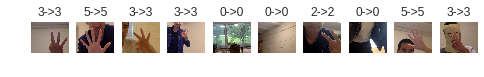

Accuracy: 1.0


In [9]:
begin = random.randrange(0, test_total-10)
end = begin + 10
res, accuracy_val = sessRes.run([predict, accuracy], feed_dict = {img_holder: test_images[begin:end], lbl_holder:test_labels[begin:end], train: False})
titles = [str(np.argmax(test_labels[i])) + '->' + str(res[i-begin]) for i in range(begin, end)] 
plotImg(test_images[begin:end], titles)
print('Accuracy:', accuracy_val)

In [0]:
sessRes.close()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [12]:
#------------------------------------------------
#    Replace google drive trained model with new one
#------------------------------------------------
!rm -rf Hybrid7.zip
!zip -r Hybrid7.zip checkpoints
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3' in parents"}).GetList()

for f in file_list:
  # delete old one
  fname = f['title']
  print('Deleting', fname)
  f.Delete()
file_metadata = {'title': 'Hybrid7.zip', "parents": [{"id": '19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3', "kind": "drive#childList"}]}
# Create & upload a file.
uploaded = drive.CreateFile(file_metadata)
uploaded.SetContentFile('Hybrid7.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/cnnGesture/ (stored 0%)
  adding: checkpoints/cnnGesture/checkpoint (deflated 39%)
  adding: checkpoints/cnnGesture/model.data-00000-of-00001 (deflated 18%)
  adding: checkpoints/cnnGesture/model.index (deflated 50%)
  adding: checkpoints/cnnGesture/model.meta (deflated 90%)
Deleting Hybrid7.zip
Uploaded file with ID 1wLNzvhDseuJrOxfsAvnikpsKzQFY7N1_
